# Análise Exploratória e Treinamento de Modelo de Imagem

Neste notebook, será eralizada uma análise exploratória sobre uma base de dados de imagens e definiremos um modelo de rede neural para classificação de imagens. Está dividido nas seguintes etapas:
1. Importação das Bibliotecas
2. Carregamento e Visualização dos Dados
3. Pré-processamento dos Dados
4. Definição da Arquitetura do Modelo
5. Compilação e Treinamento do Modelo
6. Avaliação do Modelo
7. Conclusão


## Importação das bibliotecas

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
import random
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.image as img

2024-05-20 02:14:25.215254: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 02:14:25.220379: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 02:14:25.281255: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 02:14:26.516484: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Carregamento e Visualização dos Dados
Aqui, serão carregadas as imagens da base de dados e visualizadas algumas amostras.

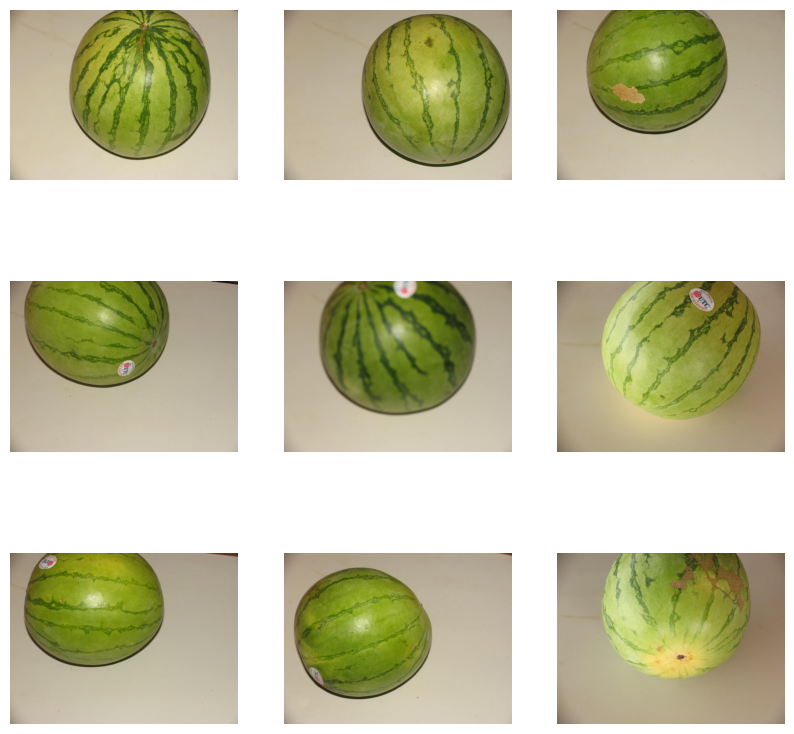

In [2]:
# Defina as dimensões das imagens e o número de classes
image_height, image_width = 128, 128
num_classes = 14  # Ajuste conforme necessário

# Função para visualizar algumas imagens
def visualize_images(image_paths, labels):
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        image = img.imread(image_paths[i])
        plt.imshow(image)
        plt.axis('off')
    plt.show()

# Definindo o caminho das imagens e os rótulos
image_paths = glob('imagens/*/*.jpg')  # Ajuste o caminho conforme necessário
labels = [int(path.split('/')[-2]) for path in image_paths]  # Extraindo rótulos dos caminhos

# # Embaralhar os dados
# combined = list(zip(image_paths, labels))
# random.shuffle(combined)
# image_paths[:], labels[:] = zip(*combined)

# Visualizar algumas imagens
visualize_images(image_paths, labels)

In [3]:
class GeradorSequencias(Sequence):

    def __init__(self, entradas, saidas, batch_size, num_classes):
        self.entradas = entradas
        self.saidas = saidas
        self.batch_size = batch_size
        self.num_classes = num_classes

    def __len__(self):
        return len(self.entradas) // self.batch_size

    def __getitem__(self, id):
        esquerda = id * self.batch_size
        direita = min(esquerda + self.batch_size, len(self.entradas))
        batch_entradas = self.entradas[esquerda:direita]
        batch_saidas = self.saidas[esquerda:direita]

        # Depuração: imprimir variáveis para inspecionar os valores
        x = np.array([tf.image.resize(img.imread(caminho)/255.0, (image_height, image_width)) for caminho in batch_entradas])
        
        # Depuração: verificar o caminho e o índice do rótulo
        y = []
        for caminho in batch_entradas:
            try:
                label = int(caminho.split('/')[-2])
                y.append(to_categorical(label, self.num_classes))
            except IndexError as e:
                print(f'Erro ao processar {caminho}: {e}')
        
        y = np.array(y)

        return x, y

## Pré-processamento dos Dados
Nesta seção, normalizamos as imagens e preparamos os rótulos para o treinamento.

## Definição da Arquitetura do Modelo
Nesta seção, definimos a arquitetura da rede neural.

In [4]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

/home/caze/.pyenv/versions/3.12.3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compilação e Treinamento do Modelo
Compilamos o modelo e o treinamos com os dados.

In [5]:
# Divisão dos Dados em Treino, Validação e Teste
train_size = int(0.7 * len(image_paths))
val_size = int(0.15 * len(image_paths))
test_size = len(image_paths) - train_size - val_size

train_image_paths = image_paths[:train_size]
train_labels = labels[:train_size]
val_image_paths = image_paths[train_size:train_size + val_size]
val_labels = labels[train_size:train_size + val_size]
test_image_paths = image_paths[train_size + val_size:]
test_labels = labels[train_size + val_size:]

# Criar os geradores de sequências
batch_size = 32
train_generator = GeradorSequencias(train_image_paths, train_labels, batch_size, num_classes)
val_generator = GeradorSequencias(val_image_paths, val_labels, batch_size, num_classes)
test_generator = GeradorSequencias(test_image_paths, test_labels, batch_size, num_classes)

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

Epoch 1/10


/home/caze/.pyenv/versions/3.12.3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


## Avaliação dos resultados

In [ ]:
# Avaliação do Modelo no Conjunto de Teste
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


In [ ]:
# Análise dos Resultados
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.image as mpimg

# Plotar perda e acurácia ao longo das épocas
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Treinamento')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    plt.title('Perda ao longo das épocas')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Treinamento')
    plt.plot(history.history['val_accuracy'], label='Validação')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.title('Acurácia ao longo das épocas')

    plt.show()

plot_history(history)

# Carregar as imagens de teste
def load_images(image_paths, image_height, image_width):
    images = []
    for path in image_paths:
        image = mpimg.imread(path)
        image = tf.image.resize(image, [image_height, image_width])
        images.append(image)
    return np.array(images)

test_images = load_images(test_image_paths, image_height, image_width)

# Verificar os comprimentos dos dados
print(f'Number of test samples: {len(test_images)}')
print(f'Number of test labels: {len(test_labels)}')

# Ajustar a geração de previsões
test_predictions = model.predict(test_images)
test_pred_classes = np.argmax(test_predictions, axis=1)
print(f'Predicted classes: {len(test_pred_classes)}')

true_classes = np.argmax([to_categorical(label, num_classes) for label in test_labels], axis=1)
print(f'True classes: {len(true_classes)}')

# Matriz de Confusão
if len(true_classes) == len(test_pred_classes):
    cm = confusion_matrix(true_classes, test_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
else:
    print("Mismatch in the number of test samples and predictions.")